<a href="https://colab.research.google.com/github/ProdKEYMON/Data_keymon/blob/main/DL_13_RNN_LSTM(Conv1D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/MyDrive/Colab Notebooks/D.L

/content/drive/MyDrive/Colab Notebooks/D.L


In [4]:
!pip install keras

In [10]:
!pip install attention

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.datasets import reuters, imdb

from attention import Attention

from sklearn.model_selection import train_test_split


# RNN (순환신경망)

In [3]:
# 데이터 가져오기

# 하이퍼 파라미터 설정
vocab_size = 10000 # 어휘 사전 크기
max_len = 200 # sequence 최대 길이
embedding_dim = 32 # 임베딩 (문자 >> 숫자) 차원
batch_size = 64 # 배치크기
epochs = 5 # 학습 횟수

# 데이터 가져오기
(x_train, y_train), (x_test, y_test) = \
imdb.load_data(num_words=vocab_size)

In [4]:
sequence.pad_sequences(x_train, maxlen=max_len)

array([[   5,   25,  100, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)

In [5]:
print(x_train)

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

In [6]:
print(y_train[:10])

[1 0 0 1 0 0 1 0 1 0]


In [7]:
sequence.pad_sequences(x_train, maxlen= 50)

array([[2071,   56,   26, ...,   19,  178,   32],
       [8255,    5,    2, ...,   16,  145,   95],
       [ 215,   28,  610, ...,    7,  129,  113],
       ...,
       [   4,   65,  496, ...,    4, 3586,    2],
       [  13,   18,   31, ...,   12,    9,   23],
       [7585,    8, 2197, ...,  204,  131,    9]], dtype=int32)

In [8]:
sequence.pad_sequences(x_train, maxlen= 200)
# 0의 의미? zero-padding으로서 최대의 길에 200에 맞춰서 부족한 부분들을 0으로 채움

array([[   5,   25,  100, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)

In [9]:
# sequence padding
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

In [10]:
type(x_train)

numpy.ndarray

In [11]:
# 모델생성(RNN)
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(SimpleRNN(32, return_sequences = False))
model.add(Dense(1, activation='sigmoid'))

# return_sequences = False
'''
RNN 계층 전체 sequence 대한 학습을 수행, 처리한 후, 마지막 time step 출력만 다음 층 (next layer)전달
즉, 최종상태 (context vector 문맥 젝터)를 출력 기반으로 분류

이와는 달리
return_sequences = True 일 경우, 각 time step 출력 반환, 이를 다음 RNN계층이 입력으로 사용
RNN 계층을 여러 개 쌓을 때 이를 활용
'''

'\nRNN 계층 전체 sequence 대한 학습을 수행, 처리한 후, 마지막 time step 출력만 다음 층 (next layer)전달\n즉, 최종상태 (context vector 문맥 젝터)를 출력 기반으로 분류\n\n이와는 달리\nreturn_sequences = True 일 경우, 각 time step 출력 반환, 이를 다음 RNN계층이 입력으로 사용\nRNN 계층을 여러 개 쌓을 때 이를 활용\n'

In [12]:
# 모델 컴파일 (학습 환경 설정)
model.compile(loss = 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'] )

In [13]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [14]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_train, y_train), callbacks= [early_stopping_callback])

Epoch 1/5
391/391 [==============================] - 125s 313ms/step - loss: 0.5884 - accuracy: 0.6678 - val_loss: 0.4000 - val_accuracy: 0.8388
Epoch 2/5
391/391 [==============================] - 87s 223ms/step - loss: 0.3874 - accuracy: 0.8302 - val_loss: 0.4988 - val_accuracy: 0.7522
Epoch 3/5
391/391 [==============================] - 81s 207ms/step - loss: 0.2922 - accuracy: 0.8776 - val_loss: 0.1391 - val_accuracy: 0.9598
Epoch 4/5
391/391 [==============================] - 80s 206ms/step - loss: 0.1421 - accuracy: 0.9506 - val_loss: 0.0887 - val_accuracy: 0.9796
Epoch 5/5
391/391 [==============================] - 81s 207ms/step - loss: 0.0761 - accuracy: 0.9755 - val_loss: 0.0321 - val_accuracy: 0.9955


In [ ]:
print('텍스트 정확도: %.4f'%(model.evaluate(x_test, y_test)[1]))

# LSTM

In [15]:
# 데이터 가져오기
(x_train, y_train), (x_test, y_test) = \
reuters.load_data(num_words=1000, test_split=0.2)
# num_words = 1000 빈도수가 큰 것을 기준으로 구분된 1000개, train/test 비율: 8:2

In [16]:
# 데이터 확인
category = np.max(y_train) +1
# index가 0부터 시작하니까
print(category, '종류')
print(len(x_train), '학습용 뉴스 기사')
print(len(x_test), '테스트용 뉴스 기사')


46 종류
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사


In [17]:
x_train = sequence.pad_sequences(x_train, maxlen=100)
x_test = sequence.pad_sequences(x_test, maxlen=100)
print(x_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   1   2   2   8  43
  10 447   5  25 207 270   5   2 111  16 369 186  90  67   7  89   5  19
 102   6  19 124  15  90  67  84  22 482  26   7  48   4  49   8 864  39
 209 154   6 151   6  83  11  15  22 155  11  15   7  48   9   2   2 504
   6 258   6 272  11  15  22 134  44  11  15  16   8 197   2  90  67  52
  29 209  30  32 132   6 109  15  17  12]


In [18]:
# one - hot encoding 전처리
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [19]:
# 모델 구조
model = Sequential()
model.add(Embedding(1000,100))
model.add(LSTM(100, activation = 'tanh'))
# LSTM 은 tanh 을 좋아해
model.add(Dense(46, activation='softmax'))
# why 'softmax'? >> 46카테고리로 분류 (다중 분류)

In [20]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# 학습의 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

# 모델 실행

In [22]:
history = model.fit(x_train, y_train, batch_size=20, epochs=100, validation_data=(x_train, y_train), callbacks=[early_stopping_callback])

Epoch 1/100
450/450 [==============================] - 28s 56ms/step - loss: 2.1302 - accuracy: 0.4588 - val_loss: 2.1158 - val_accuracy: 0.5085
Epoch 2/100
450/450 [==============================] - 7s 15ms/step - loss: 1.8012 - accuracy: 0.5375 - val_loss: 1.6672 - val_accuracy: 0.5645
Epoch 3/100
450/450 [==============================] - 7s 16ms/step - loss: 1.7379 - accuracy: 0.5607 - val_loss: 1.7040 - val_accuracy: 0.5559
Epoch 4/100
450/450 [==============================] - 6s 14ms/step - loss: 1.6540 - accuracy: 0.5731 - val_loss: 1.5631 - val_accuracy: 0.5929
Epoch 5/100
450/450 [==============================] - 5s 12ms/step - loss: 1.5565 - accuracy: 0.5921 - val_loss: 1.4692 - val_accuracy: 0.6126
Epoch 6/100
450/450 [==============================] - 5s 12ms/step - loss: 1.4394 - accuracy: 0.6244 - val_loss: 1.3221 - val_accuracy: 0.6597
Epoch 7/100
450/450 [==============================] - 5s 11ms/step - loss: 1.2835 - accuracy: 0.6742 - val_loss: 1.1912 - val_accuracy

In [23]:
print('텍스트 정확도: %.4f'%(model.evaluate(x_test, y_test)[1]))

71/71 [==============================] - 1s 8ms/step - loss: 1.8678 - accuracy: 0.6937
텍스트 정확도: 0.6937


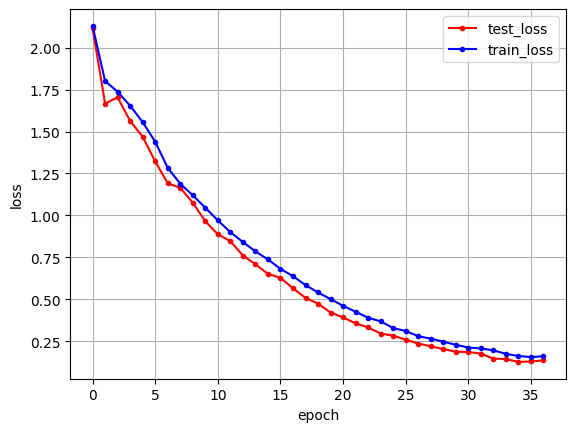

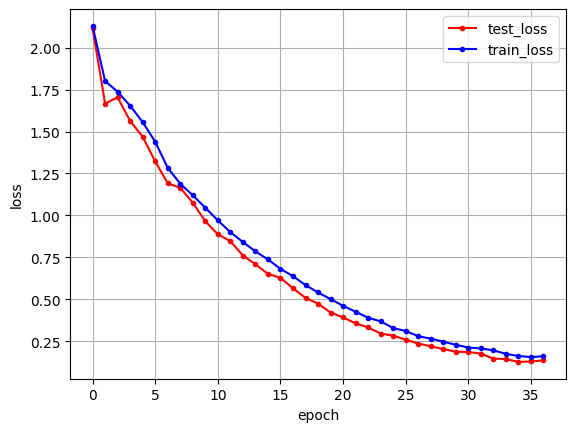

In [25]:
# 데이터 시각화
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='test_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show(0)

LSTM / CNN 조합 >> IMDB 영화 리뷰 분류

In [24]:
# 데이터 불러오기

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000)

In [26]:
x_train = sequence.pad_sequences(x_train, maxlen=500)
x_test = sequence.pad_sequences(x_test, maxlen=500)

In [27]:
# 모델 구조 설정
model = Sequential()
model.add(Embedding(5000, 100))
# Embedding(5000, 100) vocab size = 5000, 각 단어를 나타내는 임베딩 벡터 차원 (100차원)
model.add(Dropout(0.5))

model.add(Conv1D(64, 5, padding='valid', activation='relu'))
# 64개 필터 개수, 5는 필터 크기
# padding = 'valid' zero_padding 없이 convolution 통과한 출력 값 사용

# CNN (Conv1D)
model.add(MaxPooling1D(pool_size=4))
# pool_size = 4 >> 4개 중 최대값 추출

# LSTM
model.add(LSTM(50))
# LSTM 50개의 유닛 갯수

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         500000    
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 64)          0         
 D)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 50)                23000     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                      

In [ ]:
'''
(1) embedding_2 (Embedding)
vocab_size = 5000(vocab_size) * 100(차원수) = 50,000
(2) dropout (Dropout) 0.5 (50%) 정리. 너무 데이터 수가 많음
(3) conv1d (Conv1D) 100(채널 개수입력 받음), 64(필터개수), 5(핕터크기
- > (5 * 100)*64) + 64(bias) = 32064
(4) maxpooling1d (MaxPooling1D) 0
(5) lstm (LSTM)
유닛 개수 50개
입력 특징수 64
파라미터 수 4 * (64+50+1) * 50 = 23000
(6) dense (Dense) 50 * 1 + 1(bias)  = 51
'''